In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score

In [3]:
import pickle

from src.analysis import *

# Data Organization and Cleaning

In [9]:
# load data
X = pd.read_excel('data/formulations.xlsx', index_col=0) 
Y = pd.read_excel('data/measurements.xlsx', index_col=0)
df = pd.concat([X,Y], axis='columns')

In [10]:
salt_cols = list(X[['Salt-A', 'Salt-B','Salt-C']].columns)
solv_cols = list(X[['Solvent-A','Solvent-B','Solvent-C']].columns)
add_cols = list(X[['Additive-A', 'Additive-B']].columns)
meas_cols = list(Y.columns)

# Exploratory Data Analysis

In [11]:
df.head()

,Salt-A,Salt-B,Salt-C,Solvent-A,Solvent-B,Solvent-C,Additive-A,Additive-B,Measurement-1,Measurement-2,Measurement-3
Formulation,,,,,,,,,,,
F-0,0.111612,0.188388,0.000000,0.419847,0.000000,0.280153,0.000000,0.000000,17.199824,2.283883,335.616404
F-1,0.190430,0.000000,0.034570,0.000000,0.032426,0.492574,0.155820,0.094180,24.538685,1.336397,213.850473
F-2,0.069795,0.240205,0.000000,0.000000,0.194202,0.495798,0.000000,0.000000,18.140923,1.957011,322.342674
F-3,0.012005,0.000000,0.220495,0.170639,0.000000,0.346861,0.234323,0.015677,13.120480,1.904745,304.612752
F-4,0.039426,0.000000,0.280574,0.143685,0.536315,0.000000,0.000000,0.000000,21.145151,1.594739,294.821146


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, F-0 to F-91
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Salt-A         92 non-null     float64
 1   Salt-B         92 non-null     float64
 2   Salt-C         92 non-null     float64
 3   Solvent-A      92 non-null     float64
 4   Solvent-B      92 non-null     float64
 5   Solvent-C      92 non-null     float64
 6   Additive-A     92 non-null     float64
 7   Additive-B     92 non-null     float64
 8   Measurement-1  92 non-null     float64
 9   Measurement-2  92 non-null     float64
 10  Measurement-3  92 non-null     float64
dtypes: float64(11)
memory usage: 8.6+ KB


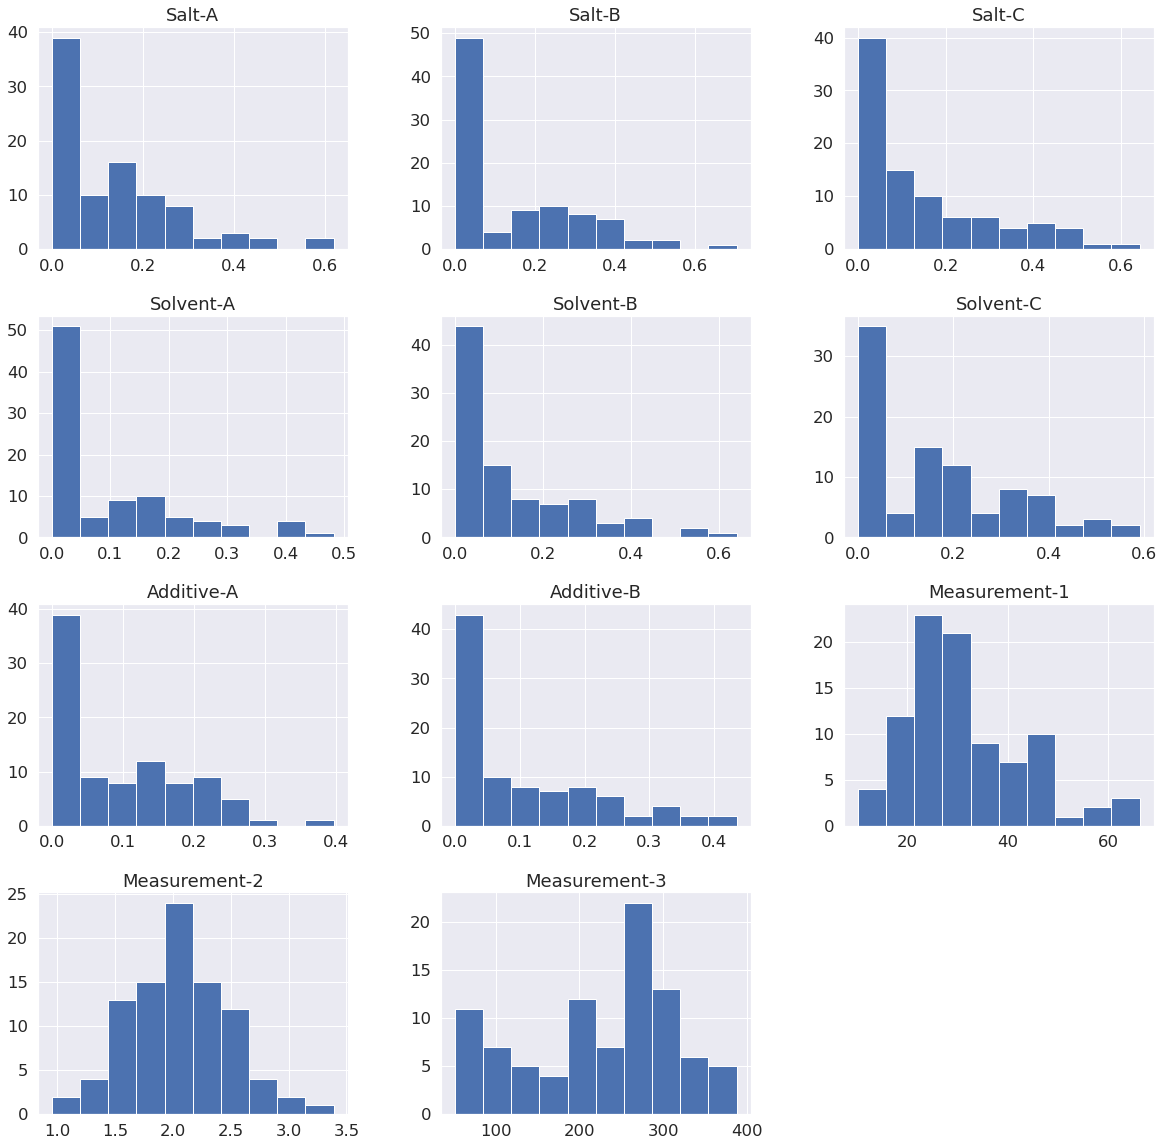

In [13]:
_ = df.hist(figsize=(20,20))

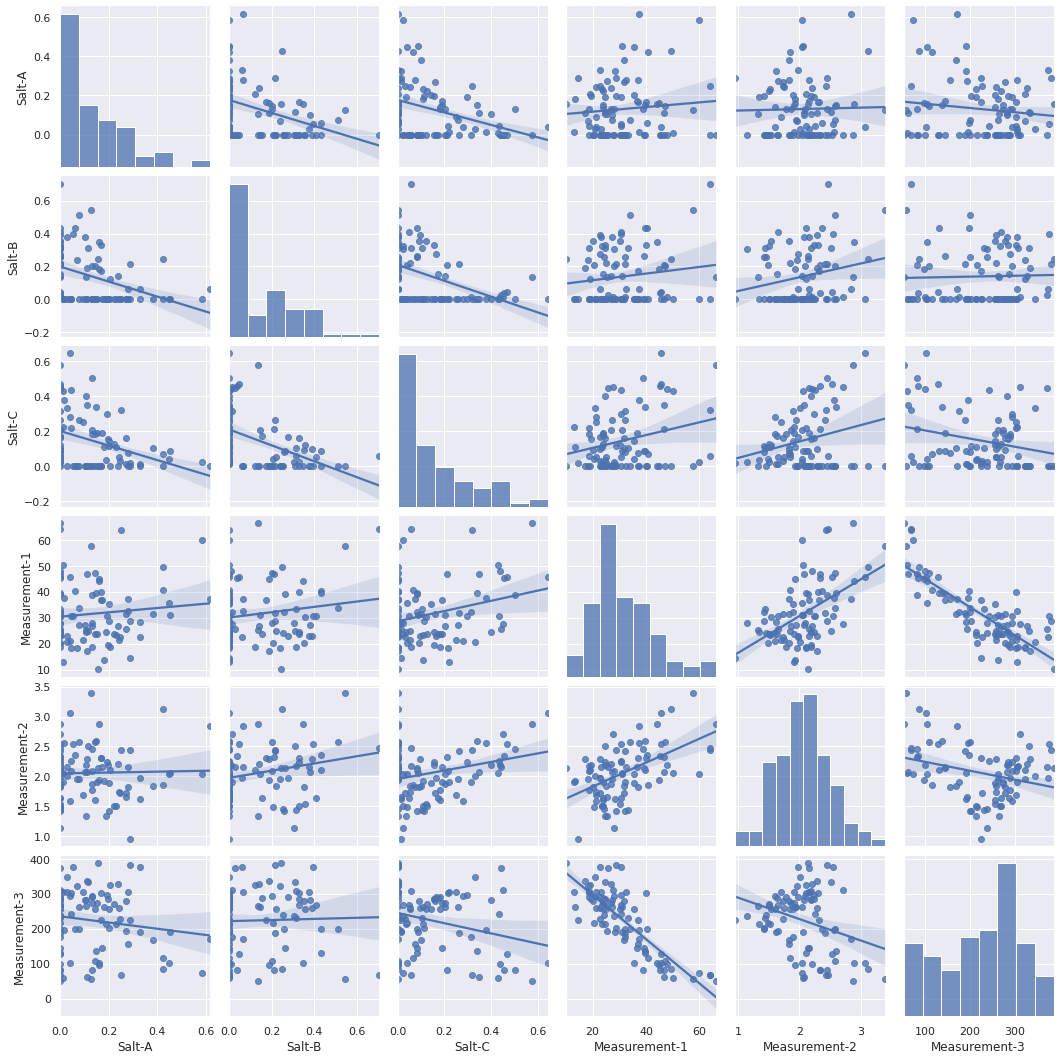

In [14]:
sns.set()
_ = sns.pairplot(df, vars=salt_cols+meas_cols, kind='reg')

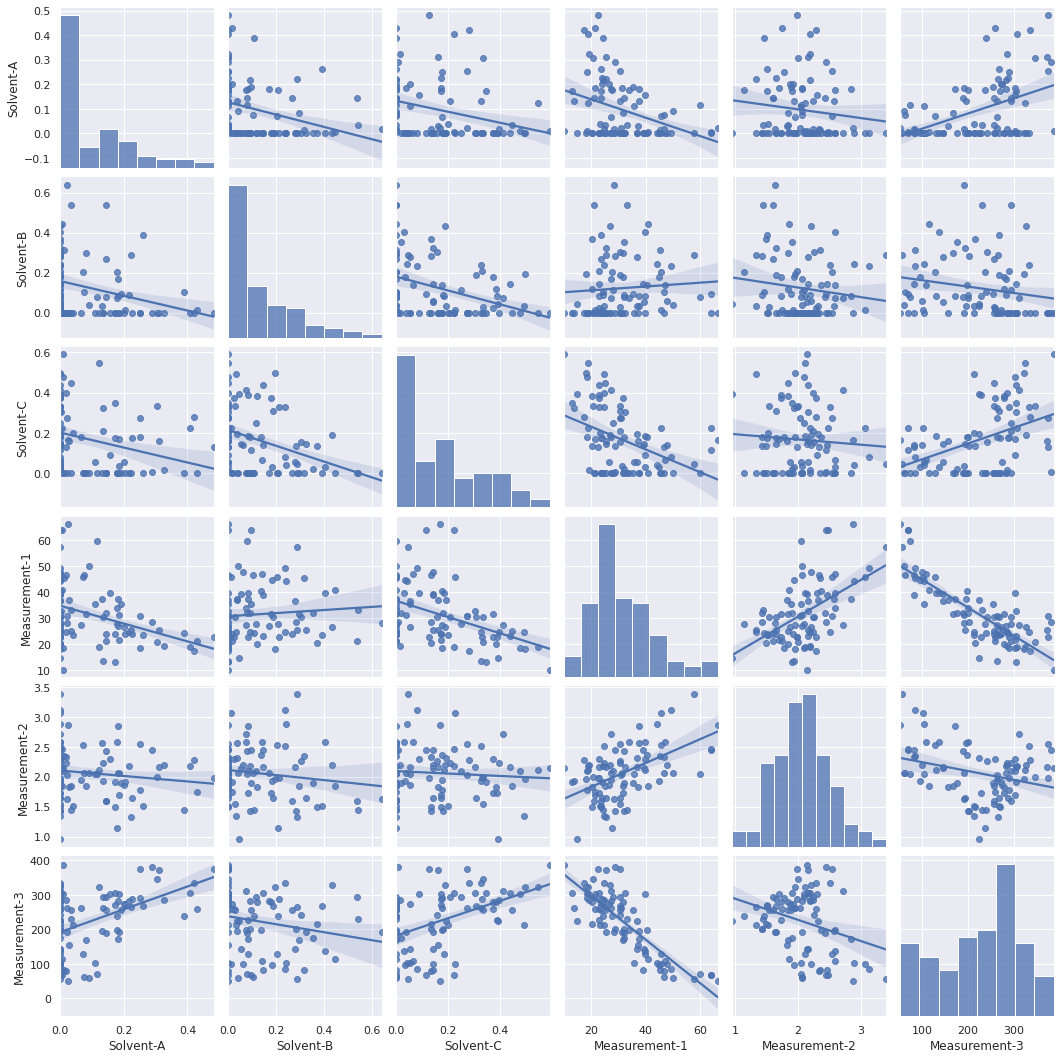

In [15]:
sns.set(font_scale=1)
_ = sns.pairplot(df, vars=solv_cols+meas_cols, kind='reg')

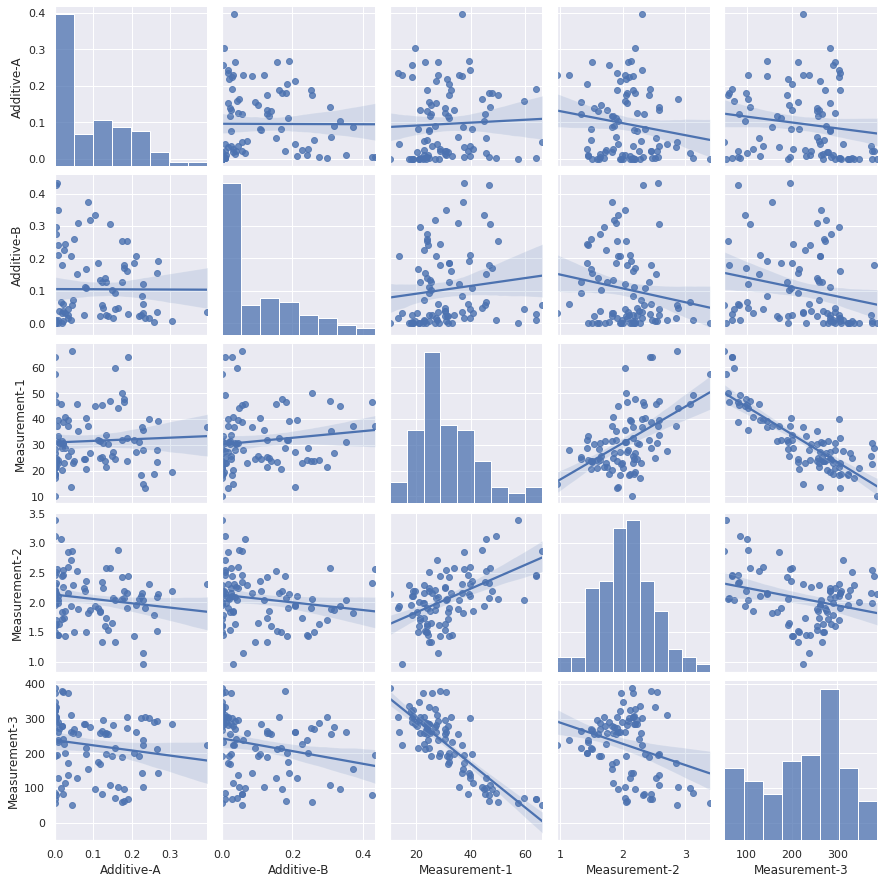

In [16]:
sns.set(font_scale=1)
_ = sns.pairplot(df, vars=add_cols+meas_cols, kind='reg')

In [17]:
# Check that they all add to 1 -> they do
X.sum(axis='columns').sum()/len(X)

1.0

In [18]:
# Check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, F-0 to F-91
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Salt-A         92 non-null     float64
 1   Salt-B         92 non-null     float64
 2   Salt-C         92 non-null     float64
 3   Solvent-A      92 non-null     float64
 4   Solvent-B      92 non-null     float64
 5   Solvent-C      92 non-null     float64
 6   Additive-A     92 non-null     float64
 7   Additive-B     92 non-null     float64
 8   Measurement-1  92 non-null     float64
 9   Measurement-2  92 non-null     float64
 10  Measurement-3  92 non-null     float64
dtypes: float64(11)
memory usage: 8.6+ KB


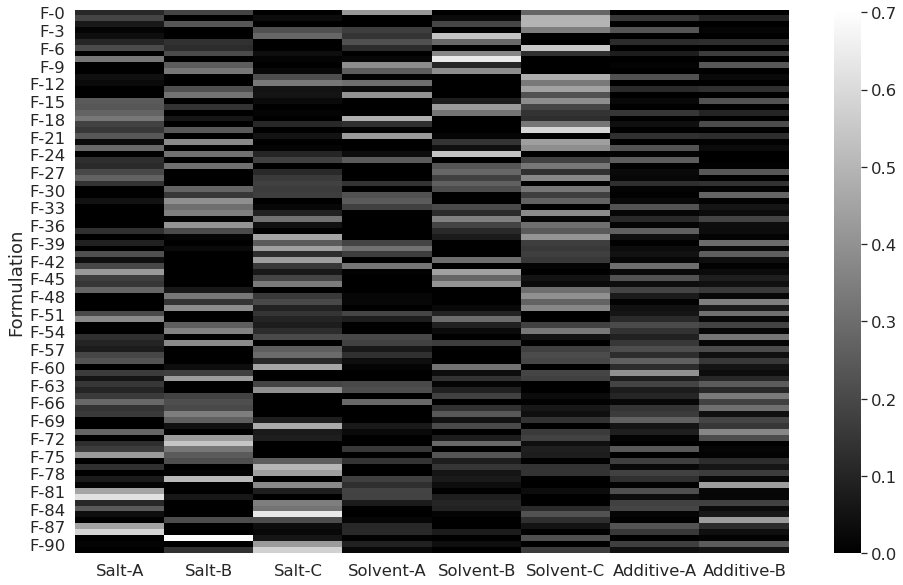

In [19]:
sns.set(font_scale=1.5)
plt.figure(figsize=(16,10))
_ = sns.heatmap(df[X.columns], cmap="gray")

In [20]:
# It looks like there might be only 2 salts and 2 solvents for every solution
# lets count the non-zero elements for each component
# number of salts
num_salts = df[salt_cols].astype(bool).sum(axis=1)
# number of solvents
num_solvents = df[solv_cols].astype(bool).sum(axis=1)
# number of additives
num_additives = df[add_cols].astype(bool).sum(axis=1)

In [21]:
print(f'Number of salts :{num_salts.unique()}')
print(f'Number of solvents :{num_solvents.unique()}')
print(f'Number of additives :{num_additives.unique()}')
# list(num_solvents.unique()), list(num_additives.unique())

Number of salts :[2]
Number of solvents :[2]
Number of additives :[0 2]


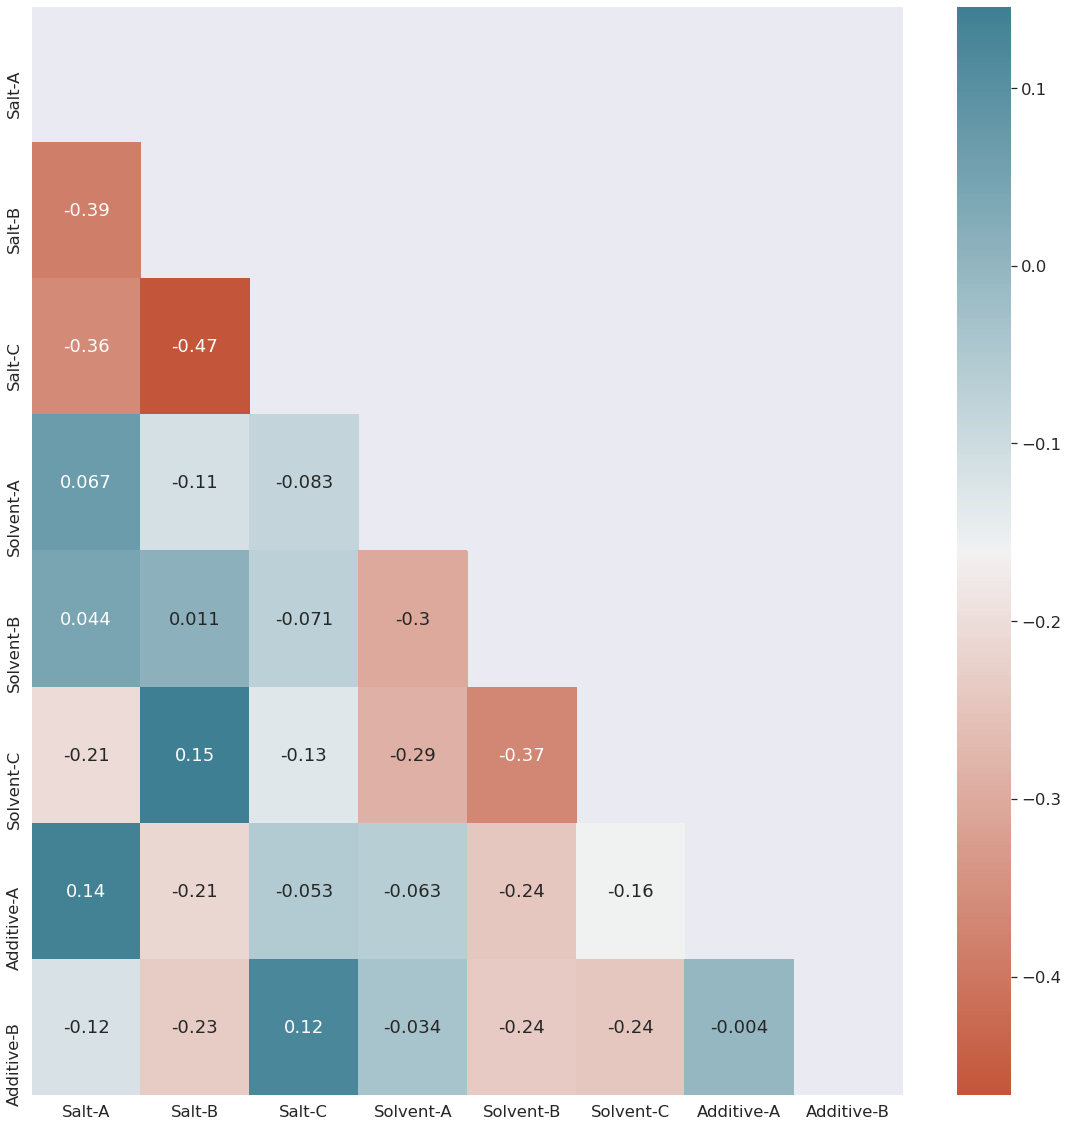

In [22]:
# Feature correlations
plot_corr(df[salt_cols+solv_cols+add_cols])

### EDA Takeaways
- The dataset contains no missing values
- All compositions add up to 1, as expected.
- The input features are generally poorly correlated. 
- `Salt-C` is the feature with the highest correlation (in particularly to `Salt-A` and `Salt-B`). We will remove it to avoid multicollinearity. Removing `Salt-C` is acceptable also because the sum of all elements adds up to 1, so we can easily derive `Salt-C` knowing the other components.
- **We observe that each compositions in our dataset is made of:**
    - 2 out of 3 salts
    - 2 out of 3 solvents
    - either 0 or 2 additives

# Feature Engineering

With a short scientific literature search we learn that the ratio between salt and solvent could be a strong predictor of cycle life performance.

From *Suo, L., Hu, YS., Li, H. et al. A new class of Solvent-in-Salt electrolyte for high-energy rechargeable metallic lithium batteries. Nat Commun 4, 1481 (2013). https://doi.org/10.1038/ncomms2513*

> It is demonstrated that the use of ‘Solvent-in-Salt’ electrolyte inhibits the dissolution of lithium polysulphide, effectively protects metallic lithium anodes against the formation of lithium dendrites and results in high lithium cycling efficiency, thus enhancing electrochemical performance.
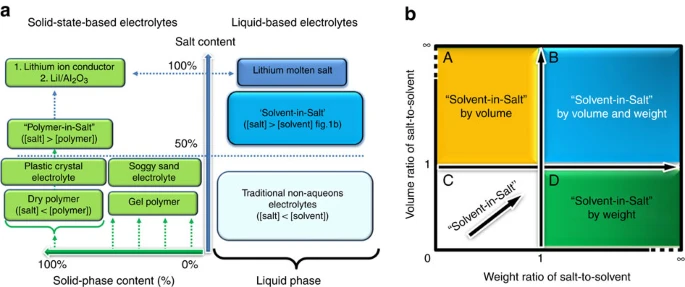


In [23]:
# sum of additives
df['tot_add'] = df[add_cols].sum(axis=1)
#sum of solvents
df['tot_salts'] = df[salt_cols].sum(axis=1)
#sum of salts
df['tot_solvents'] =  df[solv_cols].sum(axis=1)
#salt/solvent
df['solvent_salt_ratio'] = df['tot_solvents']/df['tot_salts']

eng_feats = ['tot_add', 'tot_salts', 'tot_solvents', 'solvent_salt_ratio']

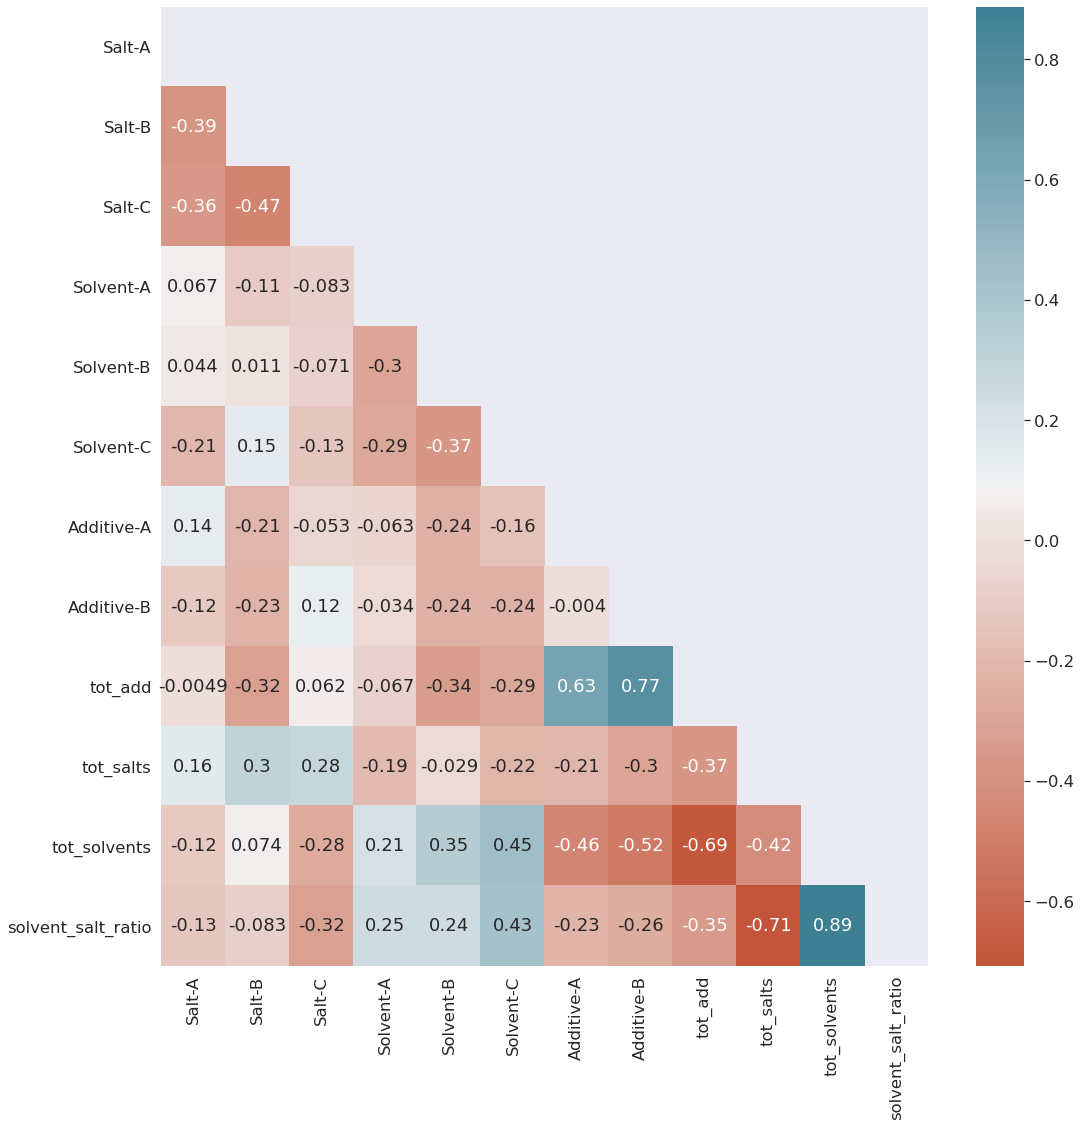

In [24]:
plot_corr(df[salt_cols+solv_cols+add_cols + eng_feats])

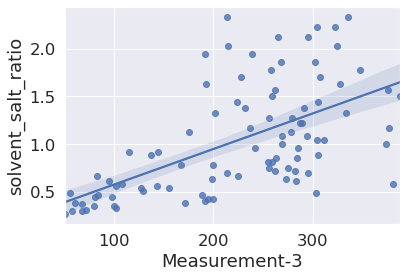

In [25]:
_ = sns.regplot(y='solvent_salt_ratio', x='Measurement-3', data=df)

### Takeaways

We engineer some features that base on literary review could be good predictor of cycle life. 
- Unsurprisingly the variables `tot_salts`, `tot_solvents`, `tot_add` show strong correlation with the featureset. We will then discard them to avoid multicollinearity. 
- As indicated by the literary review the feature `solvent_salt_ratio` is a good predictor for cycle life (`Measurement-3`), as it is generally not correlated with the remaining features we will add this to the feature set. 


# Modeling

Given the small size of the dataset, we will test a few simple models like Linear Regression and Nearest Neighbors. 

Additionally, given the goal of suggesting new compositions, we are willing to trade of better performance (which we might get with kNN or Random Forests) for simpler models (Linear Regression) that could perform better out of sample.

In [26]:
# Feature Selection
# Removing Correlated features
eng_feats.remove('tot_add')
eng_feats.remove('tot_salts')
eng_feats.remove('tot_solvents')


sel_features = salt_cols[:-1] + solv_cols + add_cols + eng_feats # salt_cols[:-1] to remove 'Salt-C'

Xx = df[sel_features].copy(deep=True)
Yy = df[meas_cols].copy(deep=True)

In [27]:
# Pre-processing
X_train, X_test, y_train, y_test = train_test_split(Xx, Yy, test_size=0.2)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train) 
X_test=scaler.transform(X_test)

In [28]:
# Modeling
# Testing multiple models


models = {'Linear':LinearRegression(),
         'kNN':KNeighborsRegressor(n_neighbors=3),
         'RFR':RandomForestRegressor(max_depth=2)}

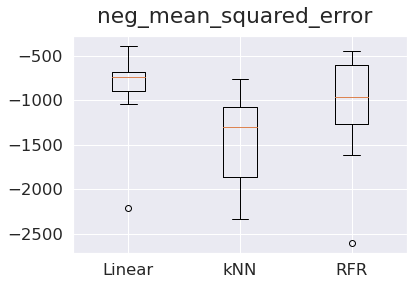

In [29]:
compare_models(models, X_train, y_train, scoring='neg_mean_squared_error')

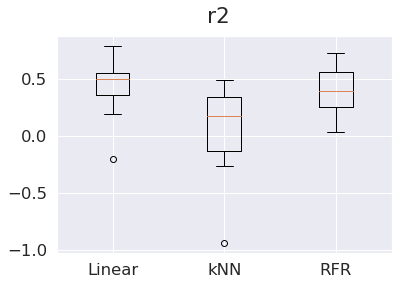

In [30]:
compare_models(models, X_train, y_train, scoring='r2')

In [31]:
# Modeling

# Selecting the model
model = models['Linear']

model.fit(X_train, y_train)

y_pred = pd.DataFrame(model.predict(X_test),
                      index=y_test.index,
                      columns=y_test.columns)

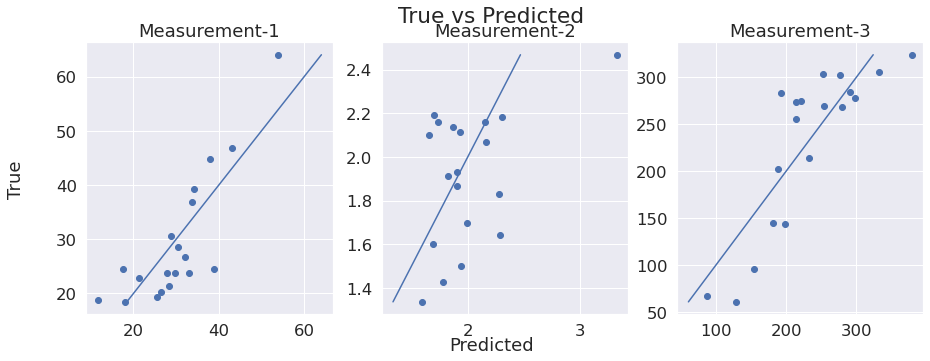

In [32]:
compare_predictions(y_pred[meas_cols], y_test[meas_cols], meas_cols, 'True vs Predicted')

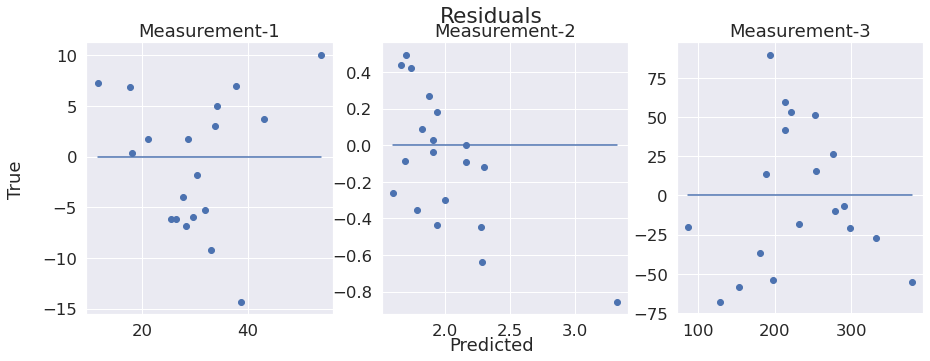

In [33]:
compare_residuals(y_pred[meas_cols], y_test[meas_cols]-y_pred[meas_cols], meas_cols, 'Residuals')

In [34]:
# Finalize model

# Train on entire dataset
X_final = scaler.fit_transform(Xx)
y_final = Yy.copy(deep=True)

final_model = models['Linear']
final_model.fit(X_final, y_final)

model_path = 'models/'

pickle.dump(final_model, open(model_path+'final_model.pkl', 'wb'))
pickle.dump(scaler, open(model_path+'scaler.pkl', 'wb'))

### Modeling Takeaways
- We scaled the data since the original features and the `solvent_salt_ratio` are on different scales
- We compared a few models and identified the Linear Regression:
    - The mean crossvalidated metrics are generally better when compared to other models.
    - The residuals look normally distributed around zero .
    - Given the task we expect better out of sample performance with a linear model as opposed to the others.

# Generating new solutions
We sample from a Dirichlet distribution to ensure the sum of all components is 1. To make the generated samples representative of the original sample populaiton we randomly generate 2 out of 3 salts and solvents, and then shuffle them with a zero component. Similarly we sample half of the new solutions without additives and half with two additives. 

In [35]:
# Generate new electrolytes
N = 1000

In [36]:
## This generates random compounds, but it is not representative of the input sample 
## because it will generally have 3 salts + 3 solvents + 2 additives

# X_new = pd.DataFrame(np.random.dirichlet(np.ones(8),size=N), 
#                      columns=df[salt_cols + solv_cols + add_cols].columns)

In [37]:
# Let's generate random samples that have a maximum of 2 out of 3 salts and solvents and either 0 or 2 additives

# let's generate compounds with 2 salts + 2 solvents + 0 additives
# We sample a Dirichlet distribution to ensure the sum is constrained to 1
tot_active_elements = 4
random_4elem = np.random.dirichlet(np.ones(tot_active_elements),size=N//2)
random_2salts = random_4elem[:,:2]
random_2solvents = random_4elem[:,2:]

# Add column of zeros
random_3salts = np.hstack((random_2salts,np.zeros((N//2,1))))
random_3solvents = np.hstack((random_2solvents,np.zeros((N//2,1))))

# Shuffle elements to randomly distribute the zero between Salt-A, B, C and Solvent-A, B, C
for i in range(0,N//2):
    np.random.shuffle(random_3solvents[i])
    np.random.shuffle(random_3salts[i])
# Add additives columns - all zeros
X_noadd =  np.hstack((random_3salts,random_3solvents, np.zeros((N//2,2))))


# let's generate compounds with 2 salts + 2 solvents + 2 additives
tot_active_elements = 6
random_6elem = np.random.dirichlet(np.ones(tot_active_elements),size=N//2)
random_2salts = random_6elem[:,:2]
random_2solvents = random_6elem[:,2:4]
random_2additives = random_6elem[:,4:]

random_3salts = np.hstack((random_2salts,np.zeros((N//2,1))))
random_3solvents = np.hstack((random_2solvents,np.zeros((N//2,1))))

for i in range(0,N//2):
    np.random.shuffle(random_3solvents[i])
    np.random.shuffle(random_3salts[i])

X_2add =  np.hstack((random_3salts, random_3solvents, random_2additives))

# Let's stack the two arrays
X_new = pd.DataFrame(np.vstack((X_noadd,X_2add)), 
                     columns=df[salt_cols + solv_cols + add_cols].columns)

In [38]:
# Check that they all add to 1 -> they do
X_new.sum(axis='columns').sum()/len(X_new)

1.0

In [39]:
# calculate solvent-salt ratio
X_new['solvent_salt_ratio'] = X_new[solv_cols].sum(axis=1)/X_new[salt_cols].sum(axis=1)
# Drop Salt-C
X_new.drop('Salt-C', axis='columns', inplace=True)


In [40]:
X_new = scaler.fit_transform(X_new)
Y_new = pd.DataFrame(model.predict(X_new),
                     columns=y_test.columns)

In [41]:
#revert to normal
X_new = pd.DataFrame(scaler.inverse_transform(X_new), columns=Xx.columns)
solvent_ratio_new = X_new.pop('solvent_salt_ratio')

In [42]:
#Total sum per row: 
X_new.loc[:,'Salt-C'] = np.abs(1-X_new.sum(axis=1)) # np.abs to correct for rouunding error near zero

In [43]:
X_new = X_new[salt_cols+solv_cols+add_cols].round(decimals=6)

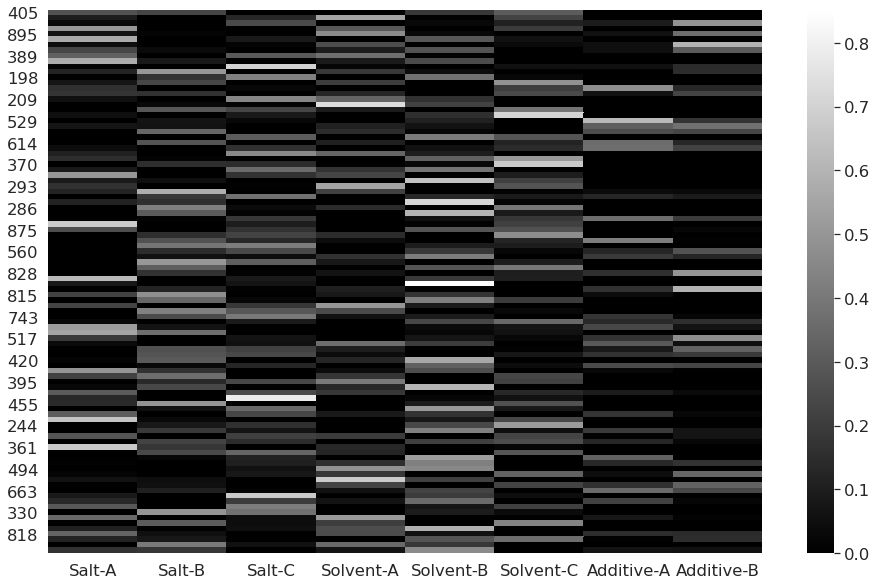

In [44]:
# Let's visualize a fraction of this new sample
sns.set(font_scale=1.5)
plt.figure(figsize=(16,10))
_ = sns.heatmap(X_new.sample(100), cmap="gray")

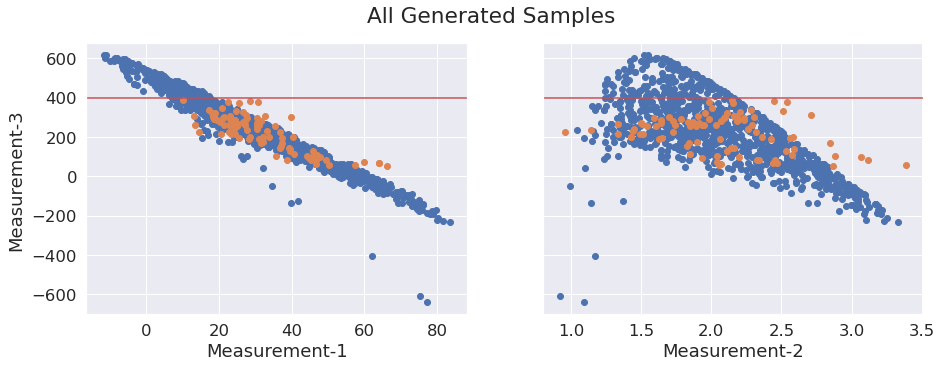

In [45]:
compare_generated_samples(Y_new, Yy, 'All Generated Samples')

## Selection method
We identify the 10 most relevant formulations by filtering based on the values of the Mesurements and of the features as follows:
- We select only formulations where `Measurement-1` and `Measurement-2` are `> 0`. This is an assumption based on the input data.
- We select formulations with at least 400 cycles (`Measurement-3 > 0`). This is our target battery cycle life
- We select formulation where the salts exceed the solvents as suggested by the publication previously referenced (`solvent_salt_ratio > 1').
- We select the 10 formulations with the highest predicted cycle life.

Please note that this selection method deliberatly selects the furthest plausible points from the previosly measured formulations. These formulations are likely to have large erorrs, since the small sample size makes the model very susceptible to extrapolation error.


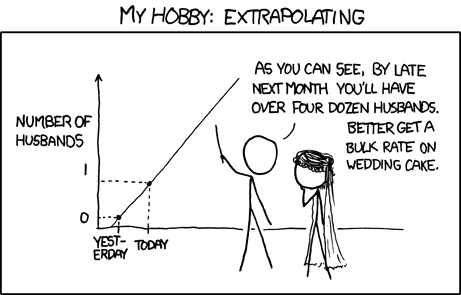
https://xkcd.com/605/

In [46]:
# filter formulation based on Measurement value
# from the input data I assume Measurement-1 and Measurement-2 need to be positive
# we filter formulations with over 400 cycles
idx_plausible_measurement = Y_new[(Y_new['Measurement-1']>0) & (Y_new['Measurement-2']>0) & (Y_new['Measurement-3']> 300)].index

# we ensure the solvent_to_ratio is bigger than one as suggested in the literature
idx_plausible_ratio = solvent_ratio_new[solvent_ratio_new>1].index

# intersecting the two conditions
idx_selection = idx_plausible_measurement.intersection(idx_plausible_ratio)

# selecting the top 10 based on the number of cycles
idx_export = Y_new.iloc[idx_selection].sort_values(by='Measurement-3',ascending=False).head(10).index

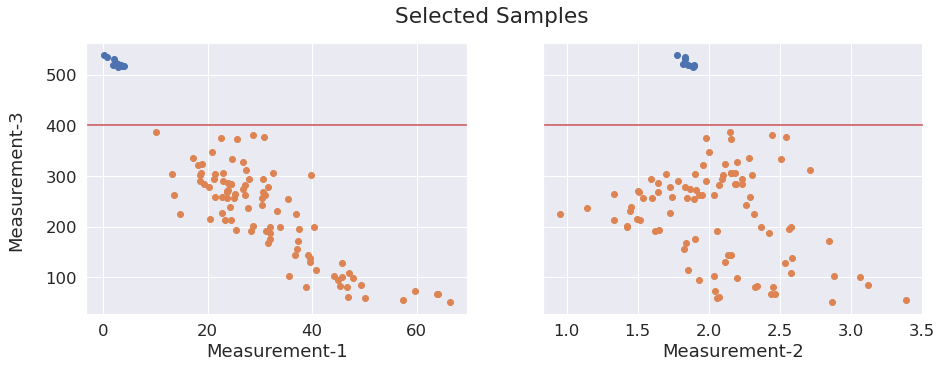

In [47]:
# Visualize selected formulations
compare_generated_samples(Y_new.iloc[idx_export], Yy, 'Selected Samples')

In [48]:
# Export to csv
X_new = X_new.rename_axis('Formulation')
X_new.iloc[idx_export].to_csv('data/suggested_formulations.csv')

Y_new = Y_new.rename_axis('Formulation')
X_new.iloc[idx_export].to_csv('data/expected_properties.csv')